# Import

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import algorithms.bernstein_vazirani as bv
import algorithms.qft as qft

from qiskit import QuantumCircuit, transpile, Aer
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.analysis import hellinger_fidelity
from qiskit.dagcircuit.dagcircuit import DAGCircuit, DAGOpNode
from qiskit.converters import circuit_to_dag


from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

# Parameters

In [58]:
def pytket(qc: QuantumCircuit, backend):
    tk_backend = IBMQBackend(backend.name, group='uw-madison')
    tk_qc = qiskit_to_tk(qc)
    tk_backend.default_compilation_pass(2).apply(tk_qc)
    tqc = tk_to_qiskit(tk_qc)
    return tqc

def qiskit_opt_0(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=0)

def qiskit_opt_3(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3)

def qiskit_opt_3_sabre(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3, layout_method='sabre', routing_method='sabre')

In [59]:
min_qubits, max_qubits = 4, 14
algorithms = { 'Bernstein Vazirani': bv, 'QFT': qft }
techniques = { 
    'PyTket': pytket,
    'Qiskit Opt 0': qiskit_opt_0, 
    'Qiskit Opt 3': qiskit_opt_3, 
    'Qiskit Opt 3 Sabre': qiskit_opt_3_sabre 
}

In [60]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_guadalupe")

In [61]:
# from qiskit.providers.fake_provider import FakeOslo
# fake_backend = FakeOslo()
# fake_backend.name = "ibm_oslo"

In [62]:
qcs = []
for al_name, al in algorithms.items():
    for n in range(min_qubits, max_qubits+1):
        qc = al.test(n)
        qcs.append(qc)

# Create Transpiled Circuits

In [63]:
tqcs = []

for qc in qcs:
    for t_name, t in techniques.items():
        tqc = t(qc, backend)
        tqcs.append(tqc)

# Run on IBM QC

In [64]:
job = backend.run(tqcs, shots=4000)
# job = fake_backend.run(tqcs, shots=1000)

# Checkpoint

In [65]:
job = provider.backend.jobs()[0]
display(job.job_id())

'cfpnbu7lq5soddt7hr4g'

## Simulate QCs

In [66]:
def simulate_classically(qc_list):
    aer_sim = Aer.get_backend('aer_simulator')
    tqc_list = transpile(qc_list, aer_sim)
    job_sim = aer_sim.run(tqc_list, shots=1000)
    results = job_sim.result()
    return results

In [67]:
sim_res_counts = simulate_classically(qcs).get_counts()

## Calculate Runtimes

In [68]:
props = backend.properties()

In [100]:
def circuit_runtime_in_ms(tqc, backend):
    dag = circuit_to_dag(tqc)
    circuit_execution_time = 0
    for s in dag.layers():
        graph: DAGCircuit = s['graph']
        gate: DAGOpNode
        max_gate_time_in_layer = 0
        for gate in graph.gate_nodes():
            q_index = [qarg.index for qarg in gate.qargs]
            g_time = props.gate_length(gate.name, q_index)
            if g_time > max_gate_time_in_layer:
                max_gate_time_in_layer = g_time
        circuit_execution_time += max_gate_time_in_layer
    return circuit_execution_time*1000

In [101]:
circuit_run_times_in_ms = []

for tqc in job.circuits():
    circuit_run_times_in_ms.append(circuit_runtime_in_ms(tqc, backend))

C:\Users\thspr\AppData\Local\Temp\ipykernel_11768\2378081819.py:9: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index = [qarg.index for qarg in gate.qargs]


In [71]:
def calculate_avg_cx_errors(backend):
    cx_gates = [g for g in backend.properties().gates if g.gate == 'cx']
    cx_error_rate = 0
    for g in cx_gates:    
        cx_error_rate += g.parameters[0].value

    avg_cx_error_rate = cx_error_rate /len(cx_gates)
    return avg_cx_error_rate

In [72]:
avg_cx_error_rate = calculate_avg_cx_errors(backend)
print('avg_cx_error_rate: ', avg_cx_error_rate)

avg_cx_error_rate:  0.014834060108850172


In [73]:
qc_res_counts = job.result().get_counts()

In [74]:
cx_counts = []
for tqc in job.circuits():
    cx_counts.append(tqc.count_ops()['cx'])

# Calculate Fidelities

In [75]:
fidelities = []
n_s = max_qubits-min_qubits+1

for al_index, al_name in enumerate(algorithms.keys()):
    for n_index in range(n_s):
        n = n_index + min_qubits
        sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
        for t_index, t_name in enumerate(techniques.keys()):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            qc_counts = qc_res_counts[tqc_index]
            hf = hellinger_fidelity(sim_res_counts_n, qc_counts)
            fidelities.append(hf)
            


# Results

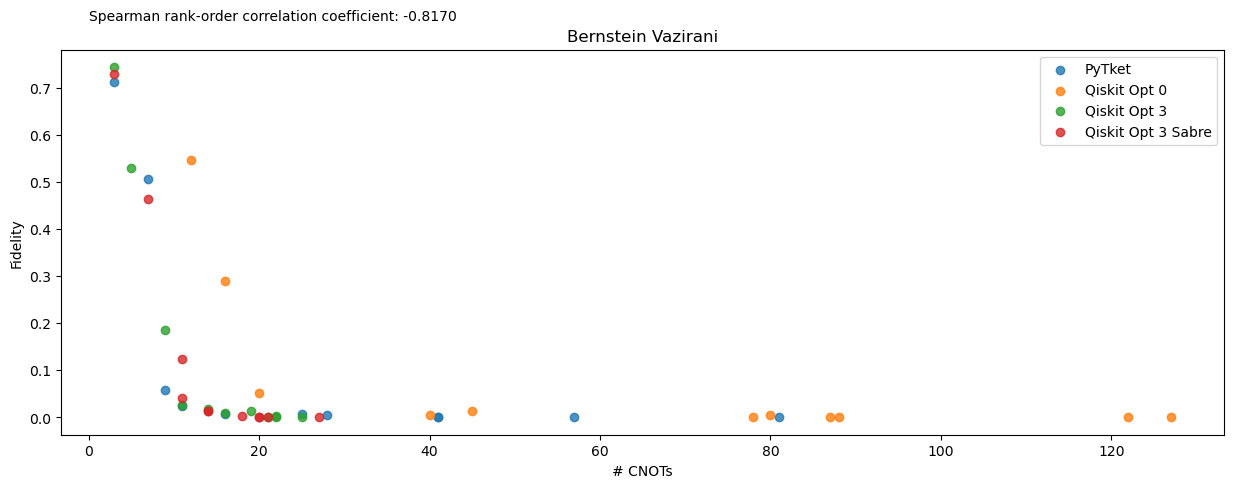

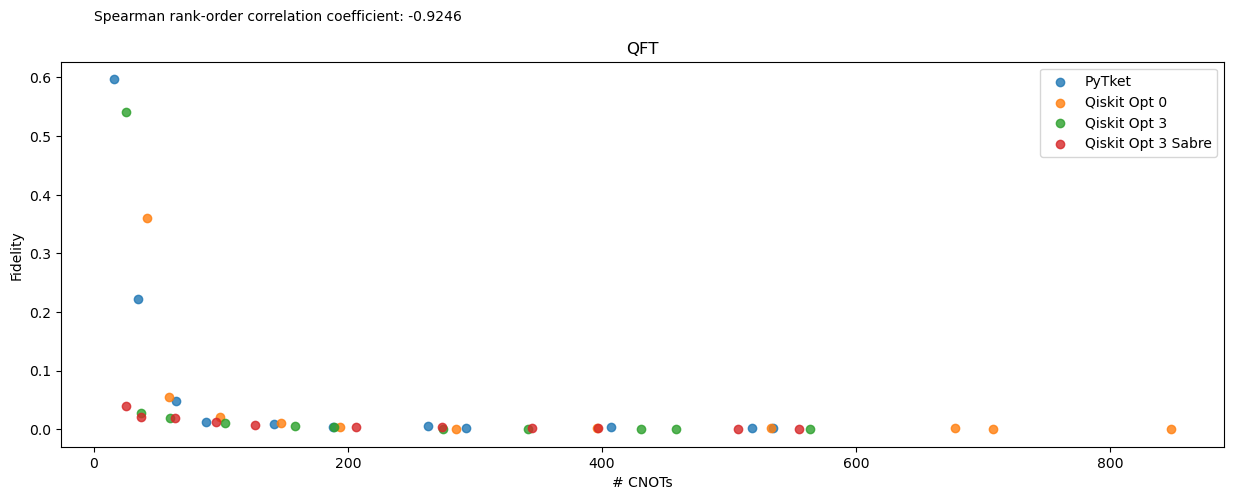

In [142]:
# fidelity vs no of cnots


for al_index, al_name in enumerate(algorithms.keys()):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set(xlabel='# CNOTs', ylabel='Fidelity', title=al_name)
    x2 = []
    y2 = []
    for t_index, t_name in enumerate(techniques.keys()):
        x = []
        y = []
        for n_index in range(n_s):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            x.append(cx_counts[tqc_index])
            y.append(fidelities[tqc_index])
        ax.scatter(x, y, label = t_name, alpha=0.8)
        ax.legend()
        x2.extend(x)
        y2.extend(y)
    res = stats.spearmanr(x2, y2)
    ax.text(0, max(y2)+0.1, 'Spearman rank-order correlation coefficient: {:2.4f}'.format(res.statistic))
    plt.show(fig)

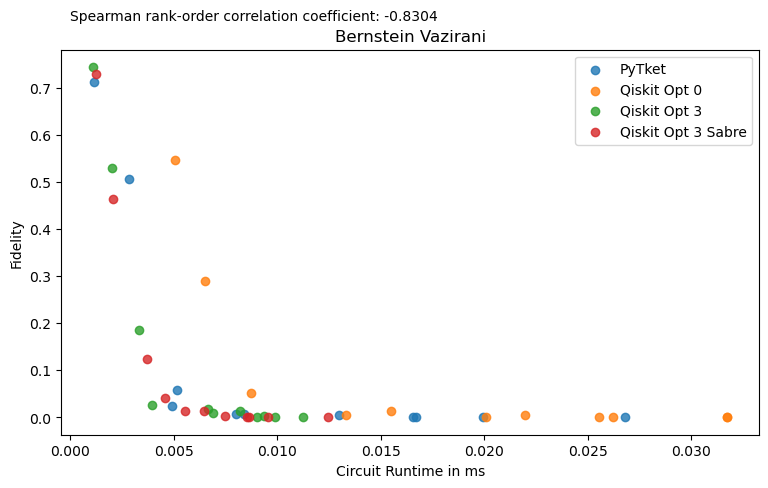

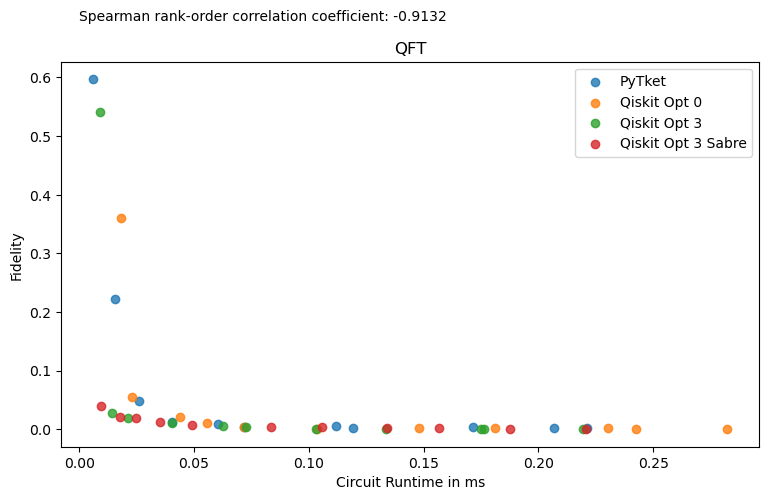

In [143]:
# fidelity vs no of runtime


for al_index, al_name in enumerate(algorithms.keys()):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set(xlabel='Circuit Runtime in ms', ylabel='Fidelity', title=al_name)
    x2 = []
    y2 = []
    for t_index, t_name in enumerate(techniques.keys()):
        x = []
        y = []
        for n_index in range(n_s):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            x.append(circuit_run_times_in_ms[tqc_index])
            y.append(fidelities[tqc_index])
        ax.scatter(x, y, label = t_name, alpha=0.8)
        ax.legend()
        x2.extend(x)
        y2.extend(y)
    res = stats.spearmanr(x2, y2)
    ax.text(0, max(y2)+0.1, 'Spearman rank-order correlation coefficient: {:2.4f}'.format(res.statistic))
    plt.show(fig)

# Test

In [145]:
res = stats.spearmanr(fidelities, cx_counts)
print(res.statistic)

-0.5997445906294252


In [ ]:
res = stats.spearmanr(fidelities, cx_counts)
print(res.statistic)

In [ ]:
# for al_index, al_name in enumerate(algorithms.keys()):
#     for n_index in range(n_s):
#         n = n_index + min_qubits
#         print('{}: n={}'.format(al_name, n))
#         sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
#         for t_index, t_name in enumerate(techniques.keys()):
#             tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
#             qc_counts = qc_res_counts[tqc_index]
#             cx_count = cx_counts[tqc_index]
#             run_time = circuit_run_times[tqc_index]
#             hf = fidelities[tqc_index]
#             print('{}: # cx gates={}, run_time={}, fidelity={}'.format(t_name, cx_count, run_time, hf))
#         print('---')
#     print('------')
            